# Table of contents
1. [Read Data](#read_data)
2. [Data Overview](#data_overview)
3. [Univariant analysis](#uni_analysis)
4. [Bivariate analysis](#bi_analysis)
5. [Modeling](#modeling)
    1. [Train-Test split](#train_test)
    2. [Preprocessing - Bucketing](#preproc)
    2. [Frequency model training](#freq_model)
    2. [Severity model training](#sev_model)
6. [Final price estimation](#final_price)

In [1]:
# # install xgboost, statsmodels
# ! conda install --name afipricing py-xgboost -y
# ! conda install --name afipricing statsmodels -y

In [2]:
# rest of packages should be installed
# in a terminal with pip install -r ./requirements.txt
# ! pip install -r ../requirements.txt

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Auxiliar functions
import libafi_SGamez as libafi

# Dynamic plotting libraries
#! pip install plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import itertools
# Run in case it needs to be installed
# ! pip install pandas_profiling
import pandas_profiling
matplotlib.use('module://ipykernel.pylab.backend_inline')
# Using statsmodel to train models
import statsmodels.api as sm
from xgboost import XGBRegressor
from patsy import dmatrices

C:\Users\Javier\AppData\Roaming\Python\Python310\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning:

p is an invalid version and will not be supported in a future release



## Read data 

In [4]:
# Data comes from R CASdatasets
# In order to get the source data, it is needed to install CASdatasets
# Then run the following R lines:
# library(data.table)
# library(CASdatasets)
# data(freMTPLfreq)
# data(freMTPLsev)
# policy_dt <- copy(freMTPLfreq)
# claims_dt <- copy(freMTPLsev)
# setDT(policy_dt)
# setDT(claims_dt)
# fwrite(policy_dt, './data/policy_data.csv', sep='|')
# fwrite(claims_dt, './data/claims_data.csv', sep='|')

# Let's read the output csv with pandas
claims_data = pd.read_csv('../data/claims_data.csv', sep='|')
policy_data = pd.read_csv('../data/policy_data.csv', sep='|')

<a name="data_overview"></a>

## Data Overview

Data description from the R package. Available at:
https://github.com/dutangc/CASdatasets/blob/master/pkg/man/freMTPL.Rd

freMTPLfreq (policy data) contains 10 columns:

* PolicyID: The policy ID (used to link with the claims dataset).
* ClaimNb: Number of claims during the exposure period.
* Exposure: The period of exposure for a policy, in years.
* Power: The power of the car (ordered categorical).
* CarAge: The vehicle age, in years.
* DriverAge: The driver age, in years (in France, people can drive a car at 18).
* Brand: The car brand divided in the following groups: A- Renaut Nissan and Citroen, B- Volkswagen, Audi, Skoda and Seat, C- Opel, General Motors and Ford, D- Fiat, E- Mercedes Chrysler and BMW, F- Japanese (except Nissan) and Korean, G- other.
* Gas: The car gas, Diesel or regular.
* Region: The policy region in France (based on the 1970-2015 classification).
* Density: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

freMTPLsev contains 2 columns:

* PolicyID: The occurence date (used to link with the contract dataset).
* ClaimAmount: The cost of the claim, seen as at a recent date.

We will use freMTPLfreq data to train a frequency model, then freMTPLsev to train a serverity model

In [5]:
policy_data.head()

PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0         1        0      0.09     g       0         46   
1         2        0      0.84     g       0         46   
2         3        0      0.52     f       2         38   
3         4        0      0.45     f       2         38   
4         5        0      0.15     g       0         41   

                                Brand      Gas              Region  Density  
0  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76  
1  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76  
2  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003  
3  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003  
4  Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire       60

In [6]:
claims_data.head()

PolicyID  ClaimAmount
0     63987         1172
1    310037         1905
2    314463         1150
3    318713         1220
4    309380        55077

In [7]:
policy_data.shape, claims_data.shape

((413169, 10), (16181, 2))

In [8]:
# PolicyID is a key, not a feature
# ClaimNb is the target, handle it separately
# Exposure is not a feature either, it will also be handled separately
freq_target = 'ClaimNb'
col_exposure = 'Exposure'
sev_target = 'ClaimAmount'
features = [c for c in policy_data.columns if c not in  ['PolicyID', freq_target, col_exposure]]

In [9]:
# Describe features, and target column
policy_data[features + [col_exposure]].describe()

CarAge      DriverAge        Density       Exposure
count  413169.000000  413169.000000  413169.000000  413169.000000
mean        7.532404      45.319876    1985.153913       0.561088
std         5.763011      14.328120    4776.254543       0.369477
min         0.000000      18.000000       2.000000       0.002732
25%         3.000000      34.000000      67.000000       0.200000
50%         7.000000      44.000000     287.000000       0.540000
75%        12.000000      54.000000    1410.000000       1.000000
max       100.000000      99.000000   27000.000000       1.990000

In [10]:
# The previous output does not capture the categorical features
# capture the categorical features, and re-run the describe
types = policy_data[features].dtypes
cat_features = types[types==object].index.values.tolist()
num_features = list(set(features) - set(cat_features))
cat_features, num_features

(['Power', 'Brand', 'Gas', 'Region'], ['DriverAge', 'Density', 'CarAge'])

In [11]:
policy_data.Region.value_counts()

Centre                160601
Ile-de-France          69791
Bretagne               42122
Pays-de-la-Loire       38751
Aquitaine              31329
Nord-Pas-de-Calais     27285
Poitou-Charentes       19046
Basse-Normandie        10893
Haute-Normandie         8784
Limousin                4567
Name: Region, dtype: int64

In [12]:
policy_data[cat_features].describe()

Power                       Brand      Gas  Region
count   413169                      413169   413169  413169
unique      12                           7        2      10
top          f  Renault, Nissan or Citroen  Regular  Centre
freq     95718                      218200   207224  160601

In [13]:
# Review claim data
# we only have policy ID and claim amount
claims_data.describe()

PolicyID   ClaimAmount
count   16181.000000  1.618100e+04
mean   185015.202151  2.129972e+03
std    117946.980398  2.106364e+04
min        33.000000  2.000000e+00
25%     83922.000000  6.980000e+02
50%    169907.000000  1.156000e+03
75%    281599.000000  1.243000e+03
max    412944.000000  2.036833e+06

<a name="uni_analysis"></a>

## Univariant analysis

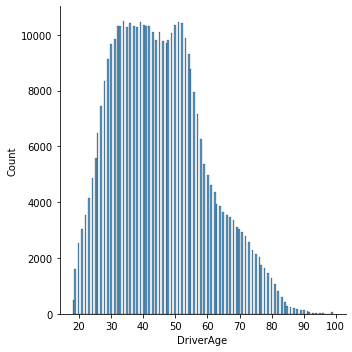

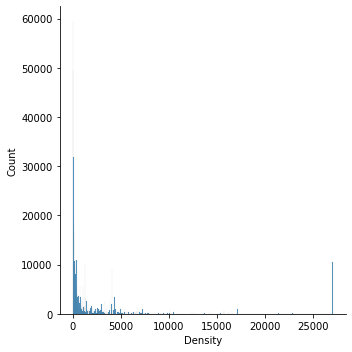

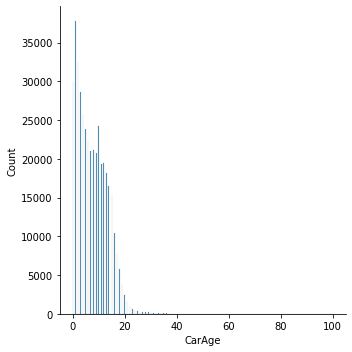

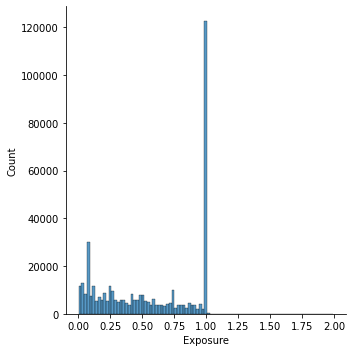

In [14]:
# Show distribution of numeric features
for num_feat in num_features + [col_exposure]:
    sns.displot(policy_data[num_feat])
    plt.show()

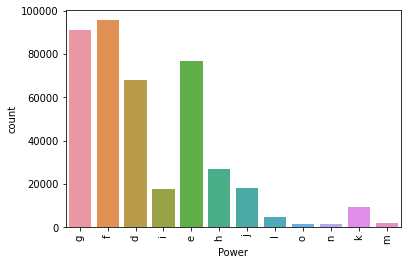

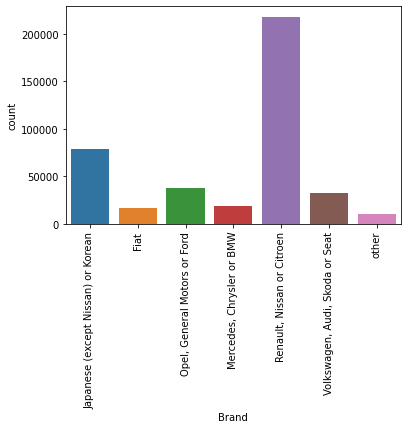

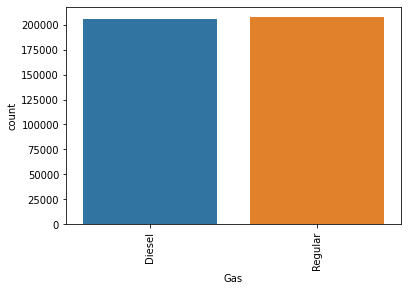

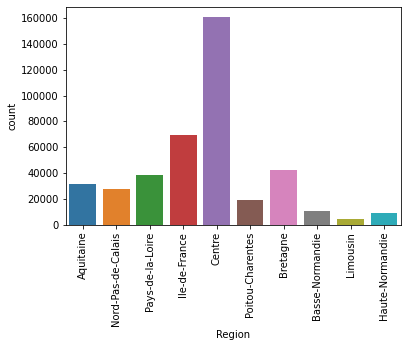

In [15]:
# Show distribution of categorical features
for cat_Feat in cat_features:
    sns.countplot(x=cat_Feat, data=policy_data)
    plt.xticks(rotation=90)
    plt.show()

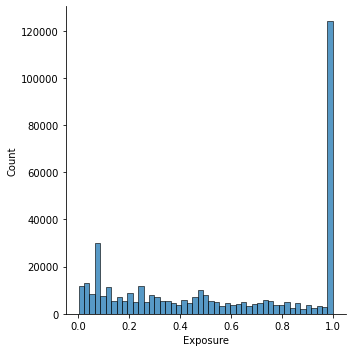

In [16]:
# One (of many possible) learning:
# Exposure has values higher than 1
# It could be a data quality issue
# Let's handle it
policy_data.loc[policy_data.Exposure > 1., 'Exposure'] = 1.
sns.displot(policy_data['Exposure'])

In [17]:
# Is there any NA in our data?
policy_data.isna().sum()

PolicyID     0
ClaimNb      0
Exposure     0
Power        0
CarAge       0
DriverAge    0
Brand        0
Gas          0
Region       0
Density      0
dtype: int64

In [18]:
claims_data.isna().sum()

PolicyID       0
ClaimAmount    0
dtype: int64

In [19]:
# No, if there was we would have to follow some policy to fill them, like:
# - Fill NA with a value outside the range of the feature
# - Fill NA with the mean
# - Fill NA with a constant
# - Fill NA with the result of some sort of inference on that feature

Recommended tool: pandas_profiling, available at: https://github.com/pandas-profiling/pandas-profiling

In [20]:
profile = pandas_profiling.ProfileReport(policy_data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# Output to html, so it can be shared
profile.to_file('../data/data_profile.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<a name="bi_analysis"></a>

## Bivariate analysis

### Numeric vs Numeric

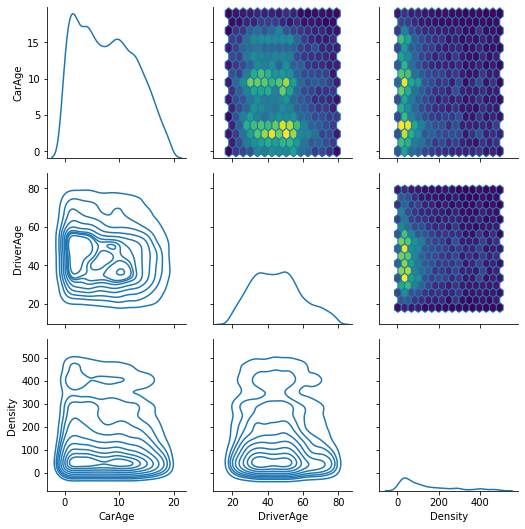

In [22]:
# Do some data filtering
# Otherwise the visualizations range are quite off
gridData = policy_data[features].sample(n=20000)
gridData = gridData.loc[gridData['CarAge'] < 20]
gridData = gridData.loc[gridData['DriverAge'] < 80]
gridData = gridData.loc[gridData['Density'] < 500]

g = sns.PairGrid(gridData)
g.map_upper(plt.hexbin, gridsize=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, legend=False)

In [23]:
# Correlation checks
corr = policy_data[features].sample(n=30000).corr()
corr

CarAge  DriverAge   Density
CarAge     1.000000  -0.049992 -0.140234
DriverAge -0.049992   1.000000 -0.004630
Density   -0.140234  -0.004630  1.000000

<AxesSubplot:>

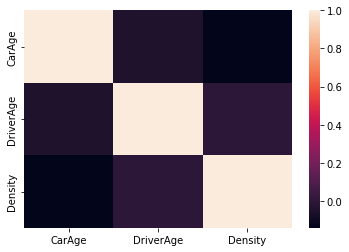

In [24]:
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Numeric vs Categorical

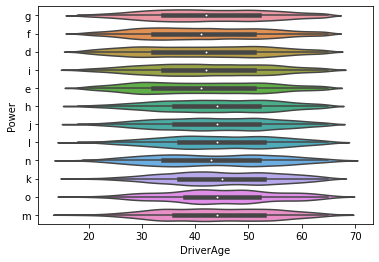

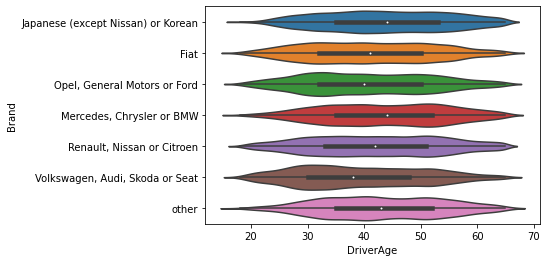

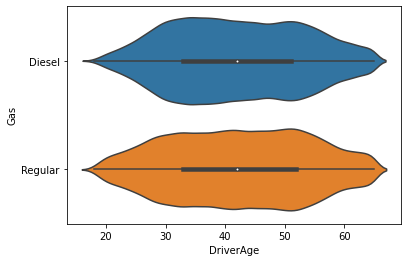

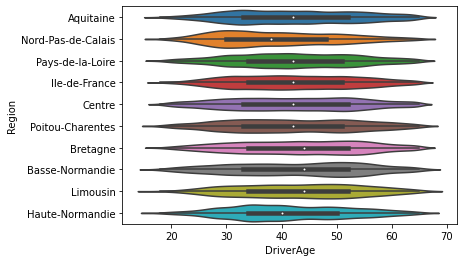

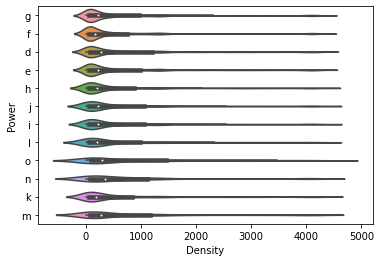

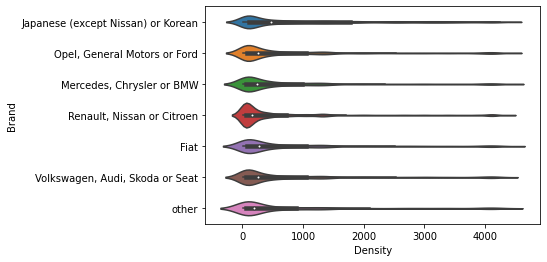

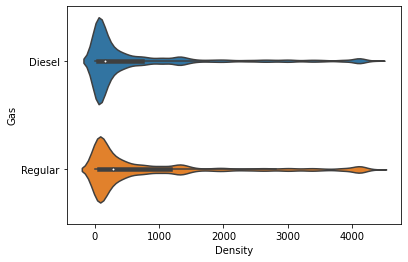

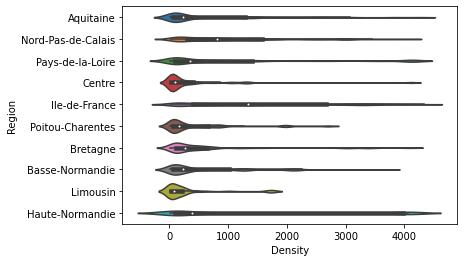

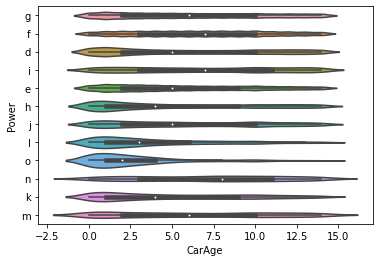

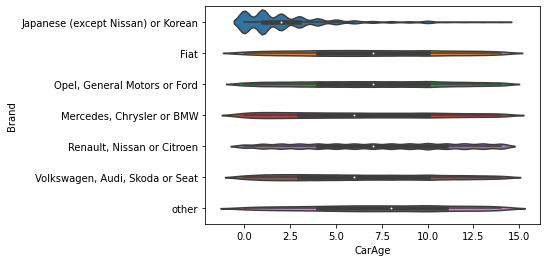

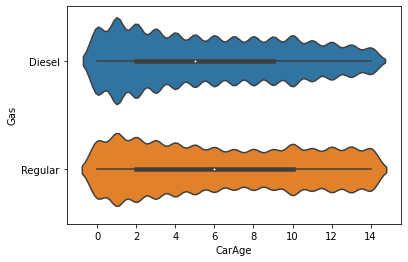

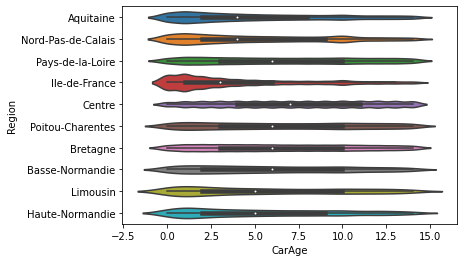

In [25]:
for num_feat in num_features:
    for cat_feat in cat_features:
        sns.violinplot(x=num_feat, y=cat_feat, kind="violin", data=policy_data.loc[policy_data[num_feat] < policy_data[num_feat].quantile(0.90)])
        plt.show()

### Categorical vs Categorical

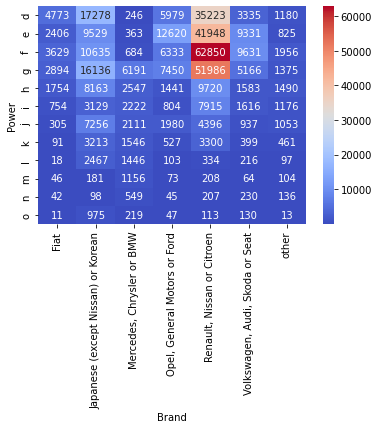

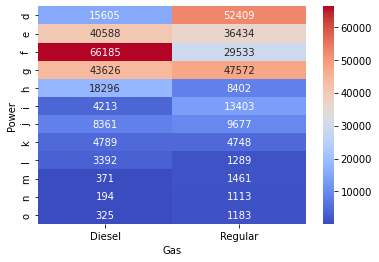

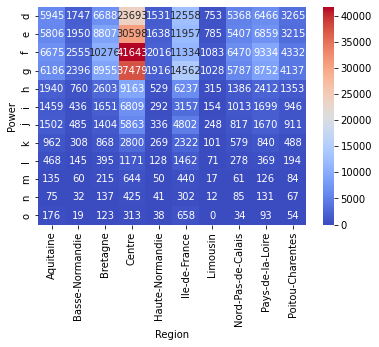

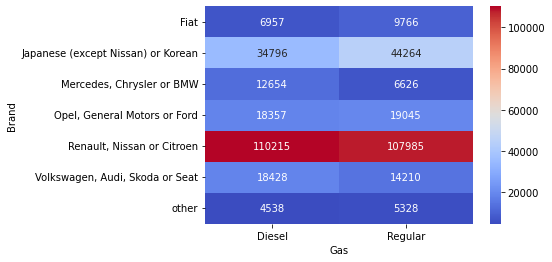

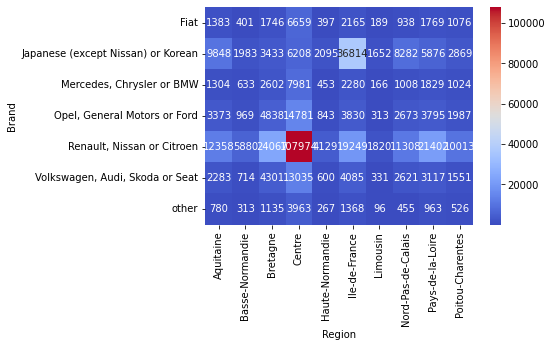

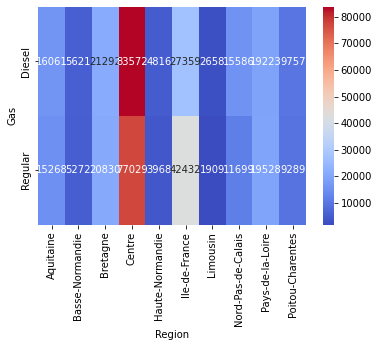

In [26]:
cat_combinations = [a for a in itertools.combinations(cat_features, 2)]

for cat_comb in cat_combinations:
        sns.heatmap(pd.crosstab(policy_data[cat_comb[0]], policy_data[cat_comb[1]]),\
                    cmap='coolwarm', annot=True, fmt="d")
        plt.show()

### ETL in order to have a single data source 

[Check duplicates](https://blog.zoho.com/wp-content/uploads/2017/09/Screen-Shot-2017-09-11-at-7.41.18-PM.png) 

In [27]:
len(policy_data), policy_data.PolicyID.nunique()

(413169, 413169)

In [28]:
len(claims_data), claims_data.PolicyID.nunique()

(16181, 15390)

In [29]:
claim_agg = claims_data.groupby('PolicyID').agg({'ClaimAmount': 'sum',
                                                 'PolicyID': 'count'})\
                                           .rename(columns={'PolicyID': 'N_claims_'})

In [30]:
claim_agg = claim_agg.reset_index()
claim_agg.head()

PolicyID  ClaimAmount  N_claims_
0        33          302          1
1        41         2001          1
2        92         1449          1
3        96        10870          2
4       142         1390          1

In [31]:
len(claim_agg)

15390

In [32]:
flat_data = policy_data.merge(claim_agg, on='PolicyID', how='left')

In [33]:
flat_data.PolicyID.shape[0]

413169

In [34]:
flat_data.head()

PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0         1        0      0.09     g       0         46   
1         2        0      0.84     g       0         46   
2         3        0      0.52     f       2         38   
3         4        0      0.45     f       2         38   
4         5        0      0.15     g       0         41   

                                Brand      Gas              Region  Density  \
0  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76   
1  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76   
2  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003   
3  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003   
4  Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire       60   

   ClaimAmount  N_claims_  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN

In [35]:
flat_data[['ClaimAmount', 'N_claims_']] = flat_data[['ClaimAmount', 'N_claims_']].fillna(0.) 

In [36]:
# Check to see if the ETL work correctly
(np.abs(flat_data['ClaimNb'] - flat_data['N_claims_'])).sum()

0.0

In [37]:
flat_data = flat_data.drop(columns='N_claims_')
flat_data.head()

PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0         1        0      0.09     g       0         46   
1         2        0      0.84     g       0         46   
2         3        0      0.52     f       2         38   
3         4        0      0.45     f       2         38   
4         5        0      0.15     g       0         41   

                                Brand      Gas              Region  Density  \
0  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76   
1  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76   
2  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003   
3  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003   
4  Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire       60   

   ClaimAmount  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

### Target Data Analysis

#### Frequency data

In [38]:
flat_data[freq_target].value_counts()

0    397779
1     14633
2       726
3        28
4         3
Name: ClaimNb, dtype: int64

In [39]:
100. * flat_data[freq_target].value_counts() / flat_data.shape[0]

0    96.275132
1     3.541650
2     0.175715
3     0.006777
4     0.000726
Name: ClaimNb, dtype: float64

In [40]:
100. * flat_data.groupby(flat_data[freq_target] > 0.).size() / flat_data.shape[0]

ClaimNb
False    96.275132
True      3.724868
dtype: float64

In [41]:
# Is 3.725% a high claim rate? Is is a good or a bad portfolio?

In [42]:
flat_data.loc[flat_data.Exposure == 1.][freq_target].mean()

0.05051705206575001

#### Severity data

<AxesSubplot:>

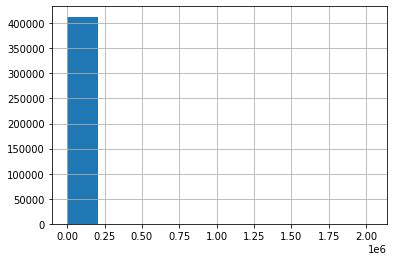

In [43]:
flat_data[sev_target].hist()

<AxesSubplot:>

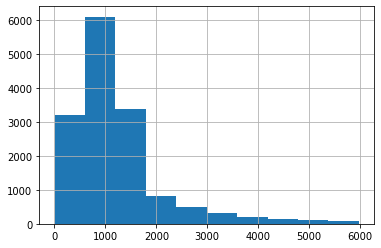

In [44]:
flat_data.loc[(flat_data[sev_target] > 0.) & (flat_data[sev_target] < 6000.)][sev_target].hist()

(array([0.000e+00, 6.000e+00, 6.000e+00, 1.400e+01, 3.100e+01, 5.000e+01,
        1.360e+02, 8.160e+02, 3.700e+02, 5.710e+02, 9.260e+02, 1.535e+03,
        8.205e+03, 1.439e+03, 7.210e+02, 2.780e+02, 1.390e+02, 5.600e+01,
        3.800e+01, 2.900e+01, 1.000e+01, 1.200e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00]),
 array([1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
        1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
        1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
        1.00000000e+03, 1.77827941e+03, 3.16227766e+03, 5.62341325e+03,
        1.00000000e+04, 1.77827941e+04, 3.16227766e+04, 5.62341325e+04,
        1.00000000e+05, 1.77827941e+05, 3.16227766e+05, 5.62341325e+05,
        1.00000000e+06, 1.77827941e+06, 3.16227766e+06, 5.62341325e+06]),
 <BarContainer object of 27 artists>)

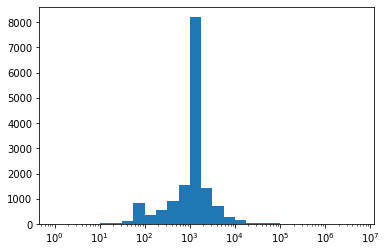

In [45]:
bins = 10**(np.arange(0, 7, 0.25))
plt.xscale('log')
plt.hist(flat_data.loc[flat_data[sev_target] > 0.][sev_target],bins=bins) 

### Feature analysis versus target data

In [46]:
? libafi.get_cut_df

In [47]:
# Example to cut data
libafi.get_cut_df('CarAge', [0, 95], 5, flat_data, freq_target)

(            cuts       N        BR
 0  (-0.001, 3.4]  129023  0.033087
 1     (3.4, 6.8]   72048  0.043568
 2    (6.8, 10.2]   86989  0.045891
 3   (10.2, 13.6]   56995  0.043214
 4   (13.6, 17.0]   50198  0.036077,
 0.0396556129871247)

In [48]:
# Example ploting feature behaviour
py.iplot(libafi.output_graph_update('CarAge', [0, 95], 7, flat_data, freq_target))

#### Feature behaviour versus frequency

In [49]:
for feat in features:
    py.iplot(libafi.output_graph_update(feat, [0, 95], 7, flat_data, freq_target))

#### Feature behaviour versus severity

In [50]:
flat_data_sev = flat_data.loc[flat_data[sev_target] < 30000]
flat_data_sev = flat_data_sev.loc[flat_data_sev["ClaimNb"]>0]
for feat in features:
    py.iplot(libafi.output_graph_update(feat, [0, 95], 7, flat_data_sev, sev_target))

<a name="modeling"></a>

## Modelling

<a name="train_test"></a>

### Train - Test split

In [51]:
flat_data_tr = flat_data.sample(frac = 0.7, random_state=42)
flat_data_test = flat_data[~flat_data.index.isin(flat_data_tr.index)].copy()

In [52]:
len(flat_data), len(flat_data_tr), len(flat_data_test)

(413169, 289218, 123951)

In [53]:
print (flat_data[[freq_target, sev_target]].mean()) 
print (flat_data_tr[[freq_target, sev_target]].mean())
print (flat_data_test[[freq_target, sev_target]].mean()) 

ClaimNb         0.039163
ClaimAmount    83.416416
dtype: float64
ClaimNb         0.039216
ClaimAmount    81.074518
dtype: float64
ClaimNb         0.039040
ClaimAmount    88.880824
dtype: float64


<a name="preproc"></a>

### Preprocessing - Bucketing

In [54]:
# ! pip install -U scikit-learn

In [55]:
# Need sklearn version > 0.20
import sklearn
sklearn.__version__

'1.0.2'

#### Handle Numeric features

In [56]:
# Numeric preprocessing set-up
# kmeans / balanced discretization strategies
? libafi.setup_numeric_prepoc

In [57]:
# Tree based discretization strategy
? libafi.setup_numtree_prepoc

In [58]:
# Using a K-means bucketing strategy
dict_enc_num_kmeans = libafi.setup_numeric_prepoc(flat_data_tr, num_features, 7, 'kmeans')
dict_enc_num_kmeans

{'DriverAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=7, strategy='kmeans'),
  'col_names': ['DriverAge_18.0_31.6',
   'DriverAge_31.6_41.3',
   'DriverAge_41.3_50.2',
   'DriverAge_50.2_59.1',
   'DriverAge_59.1_68.1',
   'DriverAge_68.1_77.0',
   'DriverAge_77.0_99.0'],
  'col_names_drop': ['DriverAge_31.6_41.3',
   'DriverAge_41.3_50.2',
   'DriverAge_50.2_59.1',
   'DriverAge_59.1_68.1',
   'DriverAge_68.1_77.0',
   'DriverAge_77.0_99.0']},
 'Density': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=7, strategy='kmeans'),
  'col_names': ['Density_2.0_1853.3',
   'Density_1853.3_4817.5',
   'Density_4817.5_8175.9',
   'Density_8175.9_13059.3',
   'Density_13059.3_19336.3',
   'Density_19336.3_24811.0',
   'Density_24811.0_27000.0'],
  'col_names_drop': ['Density_1853.3_4817.5',
   'Density_4817.5_8175.9',
   'Density_8175.9_13059.3',
   'Density_13059.3_19336.3',
   'Density_19336.3_24811.0',
   'Density_24811.0_27000.0']},
 'CarAge': {'enc': KBinsDiscretizer(e

In [59]:
# Using a quantile bucketing strategy
dict_enc_num_quant = libafi.setup_numeric_prepoc(flat_data_tr, num_features, 10, 'quantile')
dict_enc_num_quant

{'DriverAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=10),
  'col_names': ['DriverAge_18.0_28.0',
   'DriverAge_28.0_32.0',
   'DriverAge_32.0_36.0',
   'DriverAge_36.0_40.0',
   'DriverAge_40.0_44.0',
   'DriverAge_44.0_48.0',
   'DriverAge_48.0_52.0',
   'DriverAge_52.0_57.0',
   'DriverAge_57.0_66.0',
   'DriverAge_66.0_99.0'],
  'col_names_drop': ['DriverAge_28.0_32.0',
   'DriverAge_32.0_36.0',
   'DriverAge_36.0_40.0',
   'DriverAge_40.0_44.0',
   'DriverAge_44.0_48.0',
   'DriverAge_48.0_52.0',
   'DriverAge_52.0_57.0',
   'DriverAge_57.0_66.0',
   'DriverAge_66.0_99.0']},
 'Density': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=10),
  'col_names': ['Density_2.0_28.0',
   'Density_28.0_51.0',
   'Density_51.0_91.0',
   'Density_91.0_159.0',
   'Density_159.0_289.0',
   'Density_289.0_562.0',
   'Density_562.0_1165.0',
   'Density_1165.0_2404.0',
   'Density_2404.0_4348.0',
   'Density_4348.0_27000.0'],
  'col_names_drop': ['Density_28.0_51.0',
   'Densit

In [60]:
dict_enc_num_trees = libafi.setup_numtree_prepoc(flat_data_tr, num_features, col_exposure, freq_target)
dict_enc_num_trees

{'DriverAge': {'thresholds': [-inf,
   18.5,
   19.5,
   20.5,
   21.5,
   22.5,
   23.5,
   25.5,
   26.5,
   31.5,
   42.5,
   51.5,
   inf]},
 'Density': {'thresholds': [-inf,
   11.5,
   19.5,
   20.5,
   43.5,
   137.5,
   203.5,
   238.5,
   404.5,
   434.5,
   443.0,
   464.0,
   922.0,
   4073.0,
   4119.5,
   16287.5,
   inf]},
 'CarAge': {'thresholds': [-inf,
   0.5,
   1.5,
   3.5,
   7.5,
   12.5,
   14.5,
   16.5,
   17.5,
   25.5,
   26.5,
   83.5,
   inf]}}

In [61]:
# Preprocess with tree based strategy
num_tree_tr, num_tree_cols = libafi.apply_treepreproc(dict_enc_num_trees, flat_data_tr)
num_tree_test, _ = libafi.apply_treepreproc(dict_enc_num_trees, flat_data_test)

In [62]:
num_tree_tr.shape, num_tree_test.shape

((289218, 37), (123951, 37))

In [63]:
len(num_tree_cols)

37

#### Handle categorical features

In [64]:
for cat_feature in cat_features:
    display(100. * flat_data_tr[cat_feature].value_counts() / len(flat_data_tr))

f    23.113707
g    22.020414
e    18.701118
d    16.442960
h     6.473663
j     4.418812
i     4.263566
k     2.310368
l     1.129252
m     0.453291
o     0.356479
n     0.316370
Name: Power, dtype: float64

Renault, Nissan or Citroen            52.767117
Japanese (except Nissan) or Korean    19.200741
Opel, General Motors or Ford           9.051304
Volkswagen, Audi, Skoda or Seat        7.895428
Mercedes, Chrysler or BMW              4.650471
Fiat                                   4.021880
other                                  2.413059
Name: Brand, dtype: float64

Regular    50.257245
Diesel     49.742755
Name: Gas, dtype: float64

Centre                38.873791
Ile-de-France         16.923566
Bretagne              10.138719
Pays-de-la-Loire       9.400176
Aquitaine              7.576983
Nord-Pas-de-Calais     6.614734
Poitou-Charentes       4.632838
Basse-Normandie        2.594237
Haute-Normandie        2.137142
Limousin               1.107815
Name: Region, dtype: float64

In [65]:
dict_enc_cat = libafi.setup_categoric_prepoc(flat_data_tr, cat_features, 2.5)
dict_enc_cat

{'Power': {'others': ['k', 'l', 'm', 'o', 'n'],
  'enc': OneHotEncoder(sparse=False),
  'col_names': ['Power_Other',
   'Power_d',
   'Power_e',
   'Power_f',
   'Power_g',
   'Power_h',
   'Power_i',
   'Power_j'],
  'col_names_drop': ['Power_d',
   'Power_e',
   'Power_f',
   'Power_g',
   'Power_h',
   'Power_i',
   'Power_j']},
 'Brand': {'others': ['other'],
  'enc': OneHotEncoder(sparse=False),
  'col_names': ['Brand_Fiat',
   'Brand_Japane',
   'Brand_Merced',
   'Brand_Opel, ',
   'Brand_Other',
   'Brand_Renaul',
   'Brand_Volksw'],
  'col_names_drop': ['Brand_Japane',
   'Brand_Merced',
   'Brand_Opel, ',
   'Brand_Other',
   'Brand_Renaul',
   'Brand_Volksw']},
 'Gas': {'others': [],
  'enc': OneHotEncoder(sparse=False),
  'col_names': ['Gas_Diesel', 'Gas_Regula'],
  'col_names_drop': ['Gas_Regula']},
 'Region': {'others': ['Haute-Normandie', 'Limousin'],
  'enc': OneHotEncoder(sparse=False),
  'col_names': ['Region_Aquita',
   'Region_Basse-',
   'Region_Bretag',
   'Region

In [66]:
cat_enc_tr, cat_cols, cat_cols_drop = libafi.apply_encoding(dict_enc_cat, flat_data_tr)
cat_enc_test, _, _ = libafi.apply_encoding(dict_enc_cat, flat_data_test)

In [67]:
len(cat_cols), len(cat_cols_drop)

(26, 22)

In [68]:
flat_data_tr.Power.value_counts()

f    66849
g    63687
e    54087
d    47556
h    18723
j    12780
i    12331
k     6682
l     3266
m     1311
o     1031
n      915
Name: Power, dtype: int64

In [69]:
cat_cols_drop[:5]

['Power_d', 'Power_e', 'Power_f', 'Power_g', 'Power_h']

In [70]:
cat_enc_tr[:, :5].sum(axis=0)

array([47556., 54087., 66849., 63687., 18723.])

In [71]:
flat_data_tr.Region_other.value_counts()

Centre                112430
Ile-de-France          48946
Bretagne               29323
Pays-de-la-Loire       27187
Aquitaine              21914
Nord-Pas-de-Calais     19131
Poitou-Charentes       13399
Other                   9385
Basse-Normandie         7503
Name: Region_other, dtype: int64

In [72]:
cat_cols_drop[-5:]

['Region_Ile-de',
 'Region_Nord-P',
 'Region_Other',
 'Region_Pays-d',
 'Region_Poitou']

In [73]:
cat_enc_tr[:, -5:].sum(axis=0)

array([48946., 19131.,  9385., 27187., 13399.])

In [74]:
cat_enc_tr.shape, cat_enc_test.shape

((289218, 22), (123951, 22))

#### Merge both categorical and numerical processed train and test data

In [75]:
# Operative column names, with the firt bucket being previously removed
col_names = cat_cols_drop + num_tree_cols
X_tr = pd.DataFrame(np.concatenate([cat_enc_tr, num_tree_tr], axis=1), columns=col_names)
X_test = pd.DataFrame(np.concatenate([cat_enc_test, num_tree_test], axis=1), columns=col_names)
Y_freq_tr, Y_sev_tr = flat_data_tr[freq_target].reset_index(drop=True), flat_data_tr[sev_target].reset_index(drop=True)
Y_freq_test, Y_sev_test = flat_data_test[freq_target].reset_index(drop=True), flat_data_test[sev_target].reset_index(drop=True)

### Serialize preprocessing

In [76]:
# Example about how to serialize preprocessing, so it could be used
# in later modeling phases, or production
import pickle
# Put together categorical and numerical preprocessing
preproc = {'cat': dict_enc_cat,
           'tree': dict_enc_num_trees}
pickle.dump(preproc, open('../data/preproc.pkl', 'wb'))

In [77]:
load_preproc = pickle.load(open('../data/preproc.pkl', 'rb'))
load_preproc

{'cat': {'Power': {'others': ['k', 'l', 'm', 'o', 'n'],
   'enc': OneHotEncoder(sparse=False),
   'col_names': ['Power_Other',
    'Power_d',
    'Power_e',
    'Power_f',
    'Power_g',
    'Power_h',
    'Power_i',
    'Power_j'],
   'col_names_drop': ['Power_d',
    'Power_e',
    'Power_f',
    'Power_g',
    'Power_h',
    'Power_i',
    'Power_j']},
  'Brand': {'others': ['other'],
   'enc': OneHotEncoder(sparse=False),
   'col_names': ['Brand_Fiat',
    'Brand_Japane',
    'Brand_Merced',
    'Brand_Opel, ',
    'Brand_Other',
    'Brand_Renaul',
    'Brand_Volksw'],
   'col_names_drop': ['Brand_Japane',
    'Brand_Merced',
    'Brand_Opel, ',
    'Brand_Other',
    'Brand_Renaul',
    'Brand_Volksw']},
  'Gas': {'others': [],
   'enc': OneHotEncoder(sparse=False),
   'col_names': ['Gas_Diesel', 'Gas_Regula'],
   'col_names_drop': ['Gas_Regula']},
  'Region': {'others': ['Haute-Normandie', 'Limousin'],
   'enc': OneHotEncoder(sparse=False),
   'col_names': ['Region_Aquita',
    

<a name="freq_model"></a>

### Frequency model training

#### GLM based models

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_auc_score

# Poisson model to train the frequency model
# using exposure to weight observations
freq_glm_model = sm.GLM(Y_freq_tr, sm.add_constant(X_tr), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))

freq_glm_fitted = freq_glm_model.fit()
print(freq_glm_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               289218
Model:                            GLM   Df Residuals:                   289158
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47200.
Date:                Fri, 03 Jun 2022   Deviance:                       72480.
Time:                        13:40:48   Pearson chi2:                 5.14e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005266
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1

In [79]:
cols = sm.add_constant(X_tr).columns
X_n = X_tr.loc[:0, :].copy()
X_n['const'] = 1.0
display(X_n)
pred_n = freq_glm_fitted.predict(X_n[cols], 
                                    exposure=np.asarray(flat_data_tr.iloc[0:1][col_exposure]))
# smp_power
X_n_p = X_n.copy()
X_n_p['Power_g'] = 0.0
X_n_p['Power_i'] = 1.0
display(X_n_p)
pred_n_p = freq_glm_fitted.predict(X_n_p[cols], 
                                     exposure=np.asarray(flat_data_tr.iloc[0:1][col_exposure]))

print(pred_n.values, pred_n_p.values)

beta_power_i = 0.005004
beta_power_g = -0.156511
0.017105 * np.exp(beta_power_i - (beta_power_g))

Power_d  Power_e  Power_f  Power_g  Power_h  Power_i  Power_j  \
0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   

   Brand_Japane  Brand_Merced  Brand_Opel,   ...  CarAge_3.5|7.5  \
0           0.0           0.0           0.0  ...             0.0   

   CarAge_7.5|12.5  CarAge_12.5|14.5  CarAge_14.5|16.5  CarAge_16.5|17.5  \
0              0.0               0.0               0.0               0.0   

   CarAge_17.5|25.5  CarAge_25.5|26.5  CarAge_26.5|83.5  CarAge_83.5|inf  \
0               1.0               0.0               0.0              0.0   

   const  
0    1.0  

[1 rows x 60 columns]

Power_d  Power_e  Power_f  Power_g  Power_h  Power_i  Power_j  \
0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   

   Brand_Japane  Brand_Merced  Brand_Opel,   ...  CarAge_3.5|7.5  \
0           0.0           0.0           0.0  ...             0.0   

   CarAge_7.5|12.5  CarAge_12.5|14.5  CarAge_14.5|16.5  CarAge_16.5|17.5  \
0              0.0               0.0               0.0               0.0   

   CarAge_17.5|25.5  CarAge_25.5|26.5  CarAge_26.5|83.5  CarAge_83.5|inf  \
0               1.0               0.0               0.0              0.0   

   const  
0    1.0  

[1 rows x 60 columns]

[0.01710456] [0.02010282]


0.020103336944591564

In [80]:
# Predicting using exposure parameter
pred_tr = freq_glm_fitted.predict(sm.add_constant(X_tr), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test = freq_glm_fitted.predict(sm.add_constant(X_test), exposure=np.asarray(flat_data_test[col_exposure]))

In [81]:
def summary_model_performance(Y_train, Y_test, pred_train, pred_test, model_name, AUC = True):
    """Generates a small model performance summary
    
    Args:
        Y_train: Target data for train sample
        Y_test: Target data for test sample
        pred_train: Train predictions
        pred_test: Test predictions
        
    Returns:
        Pandas DataFrame with summarized performance data
    """
    summary = {'Model': model_name,
               'Sample': ['Train', 'Test'],
               'MSE': [mean_squared_error(Y_train, pred_train), mean_squared_error(Y_test, pred_test)],
               'MAE': [mean_absolute_error(Y_train, pred_train), mean_absolute_error(Y_test, pred_test)]}
    # We are working with regression models
    # AUC should not be a metric to measure
    # but we are going to asses the frecuency target
    # as 'has claim' vs 'has no claim'
    if AUC:
        summary['AUC'] = [roc_auc_score(Y_train>0, pred_train), roc_auc_score(Y_test>0, pred_test)]
    df = pd.DataFrame(summary)
    return df

In [82]:
def table_rank_ordering(y, pred, n_cuts=5):
    df_tab = pd.DataFrame(data={'y': y, 
                                'pred': pred})
    # percentile cuts
    ps = [(i/n_cuts) for i in range(n_cuts + 1)]
    cuts = df_tab.pred.quantile(ps)
    # apply cuts
    df_tab['pred_cut'] = pd.cut(df_tab['pred'], cuts, include_lowest=True)
    # return target and score means
    return df_tab.groupby('pred_cut')[['y', 'pred']].mean()

In [83]:
glm_tree_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr, pred_test, 'GLM_tree')
glm_tree_perf

Model Sample       MSE       MAE       AUC
0  GLM_tree  Train  0.041267  0.074318  0.654926
1  GLM_tree   Test  0.041269  0.074200  0.652611

In [84]:
table_rank_ordering(Y_freq_tr, pred_tr, n_cuts=8)

y      pred
pred_cut                                 
(-0.0009476, 0.00604]  0.009681  0.003200
(0.00604, 0.0134]      0.016182  0.009182
(0.0134, 0.0243]       0.027578  0.018604
(0.0243, 0.0367]       0.036070  0.030478
(0.0367, 0.0476]       0.041782  0.042327
(0.0476, 0.0581]       0.050253  0.052661
(0.0581, 0.072]        0.055720  0.064299
(0.072, 0.462]         0.076478  0.092998

In [85]:
table_rank_ordering(Y_freq_test, pred_test, n_cuts=8)

y      pred
pred_cut                                 
(-0.0009678, 0.00604]  0.009486  0.003218
(0.00604, 0.0134]      0.015106  0.009181
(0.0134, 0.0244]       0.027817  0.018709
(0.0244, 0.0368]       0.037047  0.030547
(0.0368, 0.0475]       0.044407  0.042322
(0.0475, 0.0581]       0.046663  0.052596
(0.0581, 0.0719]       0.055351  0.064292
(0.0719, 0.476]        0.076451  0.093037

In [86]:
# Try alternative preprocessing
# - Kmeans discretization
num_kmeans_tr, _, num_kmeans_cols = libafi.apply_encoding(dict_enc_num_kmeans, flat_data_tr)
num_kmeans_test, _, _ = libafi.apply_encoding(dict_enc_num_kmeans, flat_data_test)
col_names_kmeans = cat_cols_drop + num_kmeans_cols
X_tr_kmeans = pd.DataFrame(np.concatenate([cat_enc_tr, num_kmeans_tr], axis=1), columns=col_names_kmeans)
X_test_kmeans = pd.DataFrame(np.concatenate([cat_enc_test, num_kmeans_test], axis=1), columns=col_names_kmeans)
# Train
freq_glm_model_km = sm.GLM(Y_freq_tr, sm.add_constant(X_tr_kmeans), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))
freq_glm_km_fitted = freq_glm_model_km.fit()
# Predict 
pred_tr_kmeans = freq_glm_km_fitted.predict(sm.add_constant(X_tr_kmeans), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test_kmeans = freq_glm_km_fitted.predict(sm.add_constant(X_test_kmeans), exposure=np.asarray(flat_data_test[col_exposure]))
glm_kmeans_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_kmeans, pred_test_kmeans, 'GLM_kmeans')
glm_kmeans_perf

Model Sample       MSE       MAE       AUC
0  GLM_kmeans  Train  0.041375  0.074527  0.641964
1  GLM_kmeans   Test  0.041354  0.074394  0.640833

In [87]:
# - Balanced discretization
num_quant_tr, _, num_quant_cols = libafi.apply_encoding(dict_enc_num_quant, flat_data_tr)
num_quant_test, _, _ = libafi.apply_encoding(dict_enc_num_quant, flat_data_test)
col_names_quant = cat_cols_drop + num_quant_cols
X_tr_quant = pd.DataFrame(np.concatenate([cat_enc_tr, num_quant_tr], axis=1), columns=col_names_quant)
X_test_quant = pd.DataFrame(np.concatenate([cat_enc_test, num_quant_test], axis=1), columns=col_names_quant)
# Train
freq_glm_model_quant = sm.GLM(Y_freq_tr, sm.add_constant(X_tr_quant), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))
freq_glm_quant_fitted = freq_glm_model_quant.fit()
# Predict 
pred_tr_quant = freq_glm_quant_fitted.predict(sm.add_constant(X_tr_quant), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test_quant = freq_glm_quant_fitted.predict(sm.add_constant(X_test_quant), exposure=np.asarray(flat_data_test[col_exposure]))
glm_quant_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_quant, pred_test_quant, 'GLM_quant')
glm_quant_perf

Model Sample       MSE       MAE       AUC
0  GLM_quant  Train  0.041323  0.074435  0.648602
1  GLM_quant   Test  0.041311  0.074309  0.648002

#### Ensemble based models

##### Random Forest

In [88]:
# RF Regressor
from sklearn.ensemble import RandomForestRegressor
col_names_rf = cat_cols_drop + num_features
X_tr_rf = pd.DataFrame(np.concatenate([cat_enc_tr, flat_data_tr[num_features]], axis=1), columns=col_names_rf)
X_test_rf = pd.DataFrame(np.concatenate([cat_enc_test, flat_data_test[num_features]], axis=1), columns=col_names_rf)

rf_ = RandomForestRegressor(n_estimators=400, 
                           max_depth=5, 
                           min_samples_split=300, 
                           n_jobs=4)

rf_.fit(X_tr_rf, Y_freq_tr)
pred_tr_rf_ = rf_.predict(X_tr_rf)
pred_test_rf_ = rf_.predict(X_test_rf)
rf_base_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_rf_, pred_test_rf_, 'RF_base')
rf_base_perf

Model Sample       MSE       MAE       AUC
0  RF_base  Train  0.041452  0.075174  0.593140
1  RF_base   Test  0.041499  0.075069  0.579936

In [89]:
# What about exposure?
# could be considered a feature
# could also be considered as a sample weight 

# - Ideally, should be factored in as part of the loss function
col_names_rf = cat_cols_drop + num_features + [col_exposure]
X_tr_exp = pd.DataFrame(np.concatenate([cat_enc_tr, flat_data_tr[num_features + [col_exposure]]], axis=1), columns=col_names_rf)
X_test_exp = pd.DataFrame(np.concatenate([cat_enc_test, flat_data_test[num_features + [col_exposure]]], axis=1), columns=col_names_rf)

rf_ = RandomForestRegressor(n_estimators=400, 
                           max_depth=5, 
                           min_samples_split=300, 
                           n_jobs=4)

rf_.fit(X_tr_exp, Y_freq_tr)
pred_tr_rf_exp = rf_.predict(X_tr_exp)
pred_test_rf_exp = rf_.predict(X_test_exp)
rf_exp_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_rf_exp, pred_test_rf_exp, 'RF_exposure')
rf_exp_perf

Model Sample       MSE       MAE       AUC
0  RF_exposure  Train  0.041139  0.074661  0.661295
1  RF_exposure   Test  0.041170  0.074558  0.658253

##### Gradient Boosting - XGBoost

In [90]:
xgb = XGBRegressor(max_depth = 4,
                   learning_rate = 0.05,
                   n_estimators = 200,
                   n_jobs = 4)

xgb.fit(X_tr_rf, Y_freq_tr)
pred_tr_xgb = xgb.predict(X_tr_rf)
pred_test_xgb = xgb.predict(X_test_rf)
xgb_base_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_xgb, pred_test_xgb, 'XGB_base')
xgb_base_perf

/Users/gameserg/opt/anaconda3/envs/afi2022/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Model Sample       MSE       MAE       AUC
0  XGB_base  Train  0.041256  0.075005  0.621139
1  XGB_base   Test  0.041467  0.075042  0.592671

In [91]:
# Also consider exposure as feature
xgb = XGBRegressor(max_depth = 4,
                   learning_rate = 0.05,
                   n_estimators = 200,
                   n_jobs = 4)

xgb.fit(X_tr_exp, Y_freq_tr)
pred_tr_xgb_exp = xgb.predict(X_tr_exp)
pred_test_xgb_exp = xgb.predict(X_test_exp)
xgb_exp_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_xgb_exp, pred_test_xgb_exp, 'XGB_exposure')
xgb_exp_perf

/Users/gameserg/opt/anaconda3/envs/afi2022/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Model Sample       MSE       MAE       AUC
0  XGB_exposure  Train  0.040904  0.074389  0.683285
1  XGB_exposure   Test  0.041104  0.074383  0.668245

##### Review performance of all models

In [92]:
df_perf_freq = pd.concat([glm_tree_perf, glm_kmeans_perf, glm_quant_perf,
                          rf_base_perf, rf_exp_perf,
                          xgb_base_perf, xgb_exp_perf])

#Show test set performance for all models
df_perf_freq.loc[df_perf_freq.Sample=='Test'][[c for c in df_perf_freq.columns if c!= 'Sample']]

Model       MSE       MAE       AUC
1      GLM_tree  0.041269  0.074200  0.652611
1    GLM_kmeans  0.041354  0.074394  0.640833
1     GLM_quant  0.041311  0.074309  0.648002
1       RF_base  0.041499  0.075069  0.579936
1   RF_exposure  0.041170  0.074558  0.658253
1      XGB_base  0.041467  0.075042  0.592671
1  XGB_exposure  0.041104  0.074383  0.668245

<a name="sev_model"></a>

### Severity model training

In [93]:
# Re-apply tree based bucketing 
# Using the severity as target
dict_enc_numfreq_trees = libafi.setup_numtree_prepoc(flat_data_tr, num_features, col_exposure, sev_target, max_depth=3)
num_treefreq_tr, num_treefreq_cols = libafi.apply_treepreproc(dict_enc_numfreq_trees, flat_data_tr)
num_treefreq_test, _ = libafi.apply_treepreproc(dict_enc_numfreq_trees, flat_data_test)

# Actual target is amount per claim
flat_data_tr['Amnt_per_claim'] = flat_data_tr['ClaimAmount'] / flat_data_tr['ClaimNb']
flat_data_tr['Amnt_per_claim'] = flat_data_tr['Amnt_per_claim'].fillna(0.)
flat_data_test['Amnt_per_claim'] = flat_data_test['ClaimAmount'] / flat_data_test['ClaimNb']
flat_data_test['Amnt_per_claim'] = flat_data_test['Amnt_per_claim'].fillna(0.)

# Filter out outliers
flat_data_tr_sev = flat_data_tr.loc[(flat_data_tr.ClaimAmount > 0) & \
                                    (flat_data_tr.ClaimAmount < 25000 )]

In [94]:
# Alternative way to fit statsmodel
# Using patsy dmatrices, and 
# R-like formulas
formula = """Amnt_per_claim ~ C(DriverAge_tree) + C(CarAge_tree) + C(Density_tree) + C(Power_other) + 
                                     C(Brand_other) + C(Gas_other) + C(Region_other)"""

# The 'C(col_name)' in the formulas states that it is a categoric feature

response_tr, X_tr_sev = dmatrices(formula, flat_data_tr_sev, return_type='dataframe')
response_test, X_test_sev = dmatrices(formula, flat_data_test, return_type='dataframe')
sev_glm_model = sm.GLM(response_tr, X_tr_sev, 
                       family=sm.families.Gamma(link=sm.genmod.families.links.Log()),
                       freq_weights=flat_data_tr_sev[freq_target])
sev_glm_fitted = sev_glm_model.fit()
print(sev_glm_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Amnt_per_claim   No. Observations:                10711
Model:                            GLM   Df Residuals:                    11204
Model Family:                   Gamma   Df Model:                           41
Link Function:                    Log   Scale:                          1.4787
Method:                          IRLS   Log-Likelihood:                -93710.
Date:                Fri, 03 Jun 2022   Deviance:                       9659.4
Time:                        13:43:37   Pearson chi2:                 1.66e+04
No. Iterations:                    15   Pseudo R-squ. (CS):           0.007963
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [95]:
response_tr, X_tr_sev_ = dmatrices(formula, flat_data_tr, return_type='dataframe')
pred_tr_sev = sev_glm_fitted.predict(X_tr_sev)
pred_tr_sev_ = sev_glm_fitted.predict(X_tr_sev_)
pred_test_sev = sev_glm_fitted.predict(X_test_sev)
glm_sev_perf = summary_model_performance(flat_data_tr['Amnt_per_claim'], flat_data_test['Amnt_per_claim'],\
                                         pred_tr_sev_, pred_test_sev, 'Severity', False)
glm_sev_perf

Model Sample           MSE          MAE
0  Severity  Train  6.307237e+06  1398.712062
1  Severity   Test  3.720537e+07  1407.570897

<a name="final_price"></a>

In [96]:
table_rank_ordering(flat_data_test['Amnt_per_claim'], pred_test_sev, n_cuts=5)

y         pred
pred_cut                                     
(775.589, 1275.823]    56.785101  1192.428824
(1275.823, 1365.518]   70.986623  1325.456456
(1365.518, 1423.1]     54.892023  1395.943346
(1423.1, 1515.183]     82.753890  1464.462018
(1515.183, 2597.834]  154.250454  1607.712523

In [97]:
table_rank_ordering(flat_data_test.loc[flat_data_test['Amnt_per_claim']>0, 'Amnt_per_claim'], pred_test_sev, n_cuts=5)

y         pred
pred_cut                                      
(775.589, 1275.823]   1587.229989  1192.428824
(1275.823, 1365.518]  1863.455203  1325.456456
(1365.518, 1423.1]    1506.737463  1395.943346
(1423.1, 1515.183]    2208.137751  1464.462018
(1515.183, 2597.834]  4104.785177  1607.712523

In [98]:
xgb_sev = XGBRegressor(max_depth = 3,
                       learning_rate = 0.01,
                       n_estimators = 100,
                       n_jobs = 4)

idx_ht0 = flat_data_tr['Amnt_per_claim'] > 0

xgb_sev.fit(X_tr_exp[idx_ht0.values], flat_data_tr.loc[idx_ht0, 'Amnt_per_claim'])
pred_tr_xgb_sev = xgb_sev.predict(X_tr_exp)
pred_test_xgb_sev = xgb_sev.predict(X_test_exp)

xgb_sev_perf = summary_model_performance(flat_data_tr['Amnt_per_claim'], flat_data_test['Amnt_per_claim'],\
                                         pred_tr_xgb_sev, pred_test_xgb_sev, 'XGB_Severity', False)

/Users/gameserg/opt/anaconda3/envs/afi2022/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [99]:
xgb_sev_perf

Model Sample           MSE          MAE
0  XGB_Severity  Train  6.680663e+06  1410.400609
1  XGB_Severity   Test  3.766712e+07  1420.403604

In [100]:
table_rank_ordering(flat_data_test['Amnt_per_claim'], pred_test_xgb_sev, n_cuts=5)

y         pred
pred_cut                                      
(747.966, 980.623]      92.112715   951.974792
(980.623, 1206.351]     69.300634  1047.243164
(1206.351, 1426.095]    56.927886  1337.893066
(1426.095, 1651.265]    50.078234  1549.314453
(1651.265, 16498.309]  152.238917  2287.381592

In [101]:
index_ht0_te = flat_data_test['Amnt_per_claim'] > 0
table_rank_ordering(flat_data_test.loc[index_ht0_te, 'Amnt_per_claim'], pred_test_xgb_sev[index_ht0_te], n_cuts=5)

y         pred
pred_cut                                       
(747.966, 960.647]     1844.002103   931.701721
(960.647, 980.623]     1564.644621   980.527954
(980.623, 1208.061]    1510.937196  1088.870605
(1208.061, 1506.008]   1760.743816  1386.034912
(1506.008, 14291.667]  4809.437476  2174.445801

## Final price estimation

In [102]:
# We will use the tree based frequency model (freq_glm_fitted)
# and the severity model (sev_glm_fitted)

def get_premiums(data_freq, data_sev, model_freq, model_sev, exposure, quote_ratio):
    # Run frequency and severity model
    pred_freq = model_freq.predict(sm.add_constant(data_freq), exposure=exposure)
    pred_sev = model_sev.predict(data_sev)

    # Base premium = freq * sev
    base_premium = pred_freq.values * pred_sev.values
    final_premium = base_premium * (1 + quote_ratio)

    # Final output
    df_out = pd.DataFrame({'base_premium': base_premium,
                           'final_premium': final_premium})
    return df_out

In [103]:
df_premiums = get_premiums(X_tr, X_tr_sev_, freq_glm_fitted, sev_glm_fitted, flat_data_tr[col_exposure], 0.30)
df_premiums['Claim_amnt'] = flat_data_tr['ClaimAmount']
df_premiums.sum()

base_premium     1.589958e+07
final_premium    2.066946e+07
Claim_amnt       1.831116e+07
dtype: float64

In [104]:
# train set predicted premiums
# excluding outliers
df_premiums.loc[df_premiums.Claim_amnt < 25000].sum()

base_premium     1.113401e+07
final_premium    1.447421e+07
Claim_amnt       1.202568e+07
dtype: float64

<AxesSubplot:>

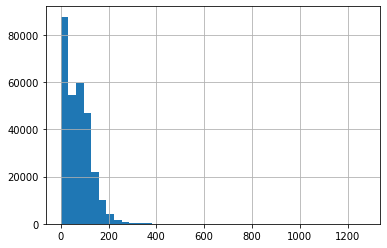

In [105]:
df_premiums.final_premium.hist(bins=40)

In [106]:
df_premiums = get_premiums(X_test, X_test_sev, freq_glm_fitted, sev_glm_fitted, flat_data_test[col_exposure], 0.30)
df_premiums['Claim_amnt'] = flat_data_test['ClaimAmount']
df_premiums.sum()

base_premium     6.818287e+06
final_premium    8.863773e+06
Claim_amnt       5.834219e+06
dtype: float64

In [107]:
# test set predicted premiums
# excluding outliers
df_premiums.loc[df_premiums.Claim_amnt < 25000].sum()

base_premium     2.056958e+06
final_premium    2.674045e+06
Claim_amnt       2.425575e+06
dtype: float64

<AxesSubplot:>

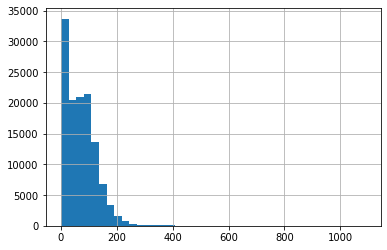

In [108]:
df_premiums.final_premium.hist(bins=40)